# Long Short-Term Memory (LSTM) Analysis

- **Date Started:** May 9th, 2024
- **Author:** Ephraim Sun

## General Overview

Price prediction models are essential for investors and traders seeking to forecast future cryptocurrency prices. One method to do so is Long Short-Term Memory (LSTM).

LSTM is a deep learning, sequential neural network that allows information to persist (1). They are a special type of Recurrent Neural Networks, where it uses previous information to process for the current input. However, RNNs cannot remember long-term dependencies due to vanishing gradient, so LSTM solves this problem.

LSTM utilizes feedback corporation, allowing it to process entire sequences of data, not just individual points. 


## Imports and Setup


In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM, Input
from tensorflow.keras.models import Sequential
import yfinance as yf

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

## Data Fetching

We decided to retrieve the top 10 best cryptocurrencies based on market cap as of 05/11/2024. We have excluded stablecoins like Tether (USDT) and USDC. Therefore, we have the following coins in order of market capitalization (excluding stablecoins): 
1) Bitcoin (BTC)
2) Ethereum (ETH)
3) Solana (SOL)
4) Binance Coin (BNB)
5) XRP (XRP)
6) Toncoin (TON)
7) Dogecoin (DOGE)
8) Cardano (ADA)
9) Shiba Inu (SHIB)
10) Avalanche (AVAX)

From the above list, we notice that we have the two main cryptocurrencies Bitcoin and Ethereum, with Bitcoin around $1.2 trillion in value (according to CoinMarketCap) and Ethereum hovering around $3.5 billion, about 3x less the value compared to Bitcoin. In addition, we have 

In [ ]:
# Define the list of top 10 cryptocurrencies
top_10_cryptos = ['BTC-USD', 'ETH-USD', 'SOL-USD', 'BNB-USD', 'XRP-USD', 'TON-USD', 'DOGE-USD', 'ADA-USD', 'SHIB-USD', 'AVAX-USD']

# Define the start and end dates
start = '2022-01-01'
end_date = '2024-01-01'

data_filepath = './data'

# Fetch historical data for each cryptocurrency
for crypto_symbol in top_10_cryptos:
    # Fetch historical data using yfinance
    crypto_data = yf.download(crypto_symbol, start=start_date, end=end_date)
    
    # Save data to a CSV file
    file_name = os.path.join(data_filepath, f"{crypto_symbol}_data.csv")
    crypto_data.to_csv(file_name)


# Now each cryptocurrency's data is saved to a separate CSV file

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


# Bitcoin


In [4]:
csv_path = './data/BTC-USD_data.csv'
df_bitcoin = pd.read_csv(csv_path, parse_dates=['Date'])

In [5]:
df_bitcoin = df_bitcoin.sort_values('Date')

In [6]:
df_bitcoin.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [7]:
df_bitcoin.shape

(3393, 7)

Text(0, 0.5, 'Close Price (USD)')

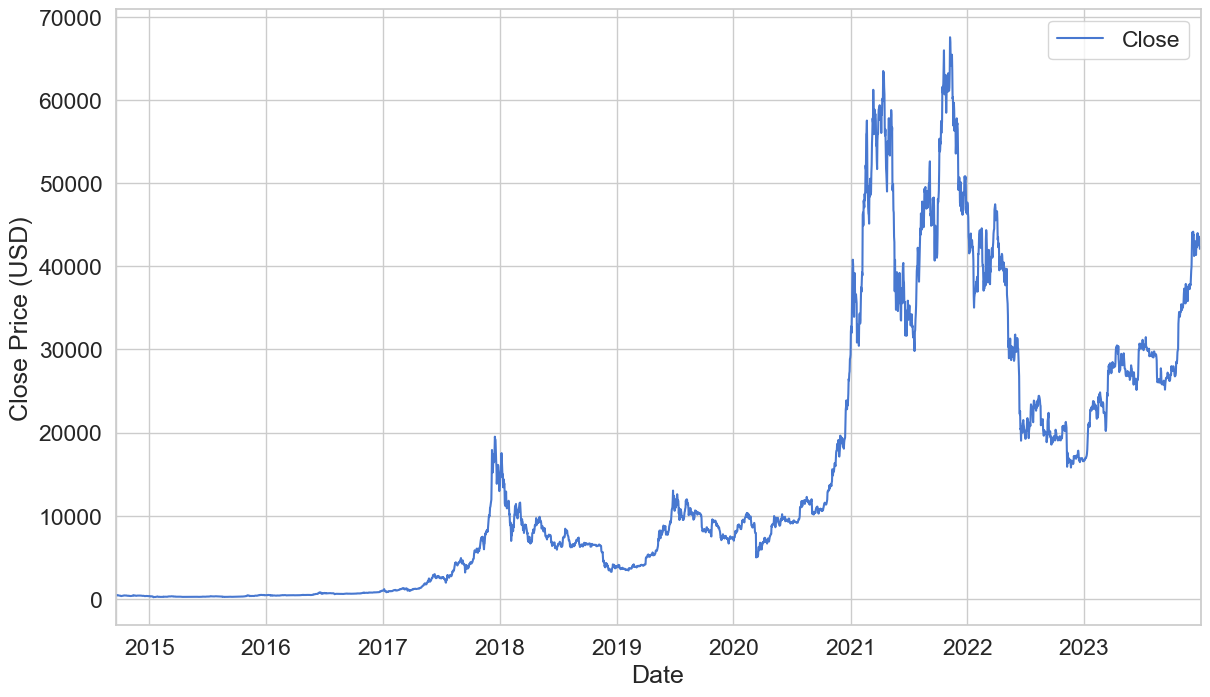

In [8]:
ax = df_bitcoin.plot(x='Date', y='Close');
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD)")

## Normalization

In [9]:
scaler = MinMaxScaler()

close_price = df_bitcoin.Close.values.reshape(-1, 1)

scaled_close = scaler.fit_transform(close_price)

In [10]:
scaled_close.shape

(3393, 1)

In [11]:
np.isnan(scaled_close).any()

False

In [12]:
scaled_close = scaled_close[~np.isnan(scaled_close)]

In [13]:
scaled_close = scaled_close.reshape(-1, 1)

In [14]:
np.isnan(scaled_close).any()

False

## Preprocessing

In [15]:
SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.95)

In [16]:
X_train.shape

(3128, 99, 1)

In [17]:
X_test.shape

(165, 99, 1)

## Model

In [18]:
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1

# Define input shape
input_shape = (WINDOW_SIZE, X_train.shape[-1])

# Define the input layer
inputs = Input(shape=input_shape)

model = keras.Sequential()

# Add the input layer to the model
model.add(inputs)

model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=True)))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(LSTM((WINDOW_SIZE * 2), return_sequences=True)))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=False)))

model.add(Dense(units=1))

model.add(Activation('linear'))


## Training

In [19]:
model.compile(
    loss='mean_squared_error', 
    optimizer='adam'
)

In [20]:
BATCH_SIZE = 64

history = model.fit(
    X_train, 
    y_train, 
    epochs=50, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    validation_split=0.1
)

Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 23s 461ms/step - loss: 0.0030 - val_loss: 0.0090
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 22s 491ms/step - loss: 0.0060 - val_loss: 0.0017
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 25s 574ms/step - loss: 0.0102 - val_loss: 0.0019
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 26s 599ms/step - loss: 0.0089 - val_loss: 0.0013
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 26s 598ms/step - loss: 0.0099 - val_loss: 0.0085
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 26s 599ms/step - loss: 0.0077 - val_loss: 0.0278
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 26s 601ms/step - loss: 0.0018 - val_loss: 0.0184
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 609ms/step - loss: 7.0384e-04 - val_loss: 8.7339e-04
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 620ms/step - loss: 0.0016 - val_loss: 2.8450e-04
Epoch 10/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 26s 587ms/step - loss: 7.0303e-04 - val_loss: 4.6427e-04
Epoch 11/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 26s 598ms/step - loss: 2.1252e-04 - val_loss: 9.7788e-04
Epoch 12/50
4

In [22]:
model.evaluate(X_test, y_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 1.6286e-04


0.0002234569110441953

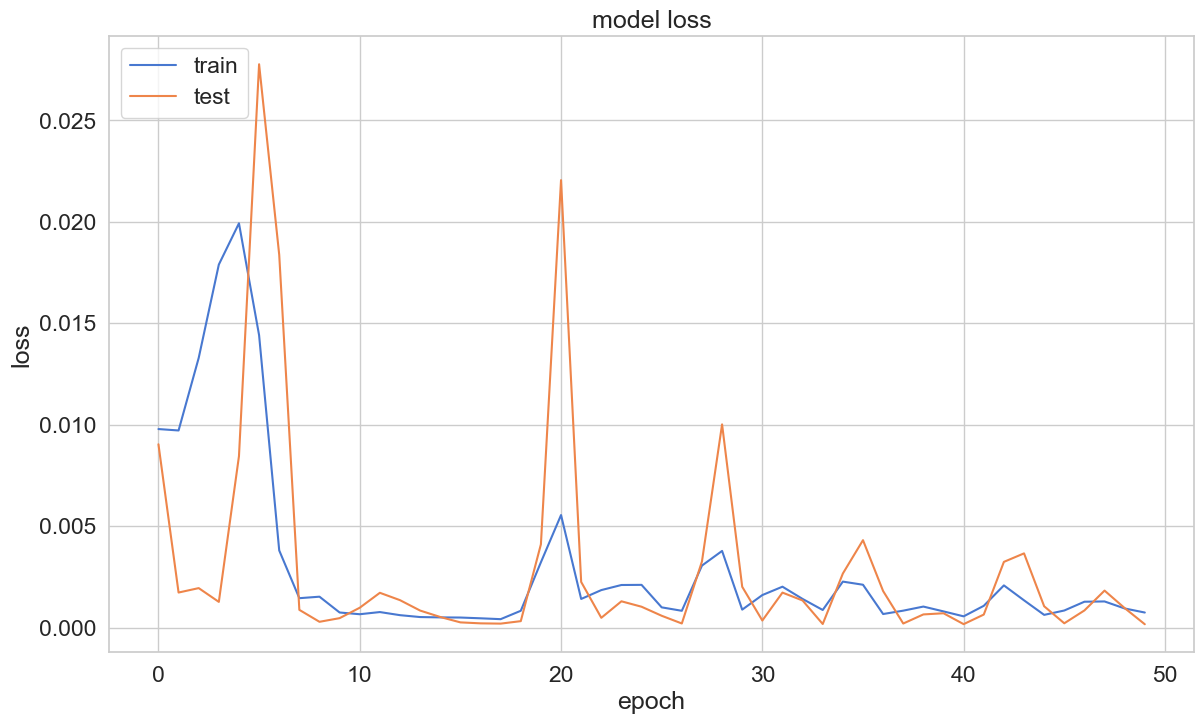

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Prediction

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step


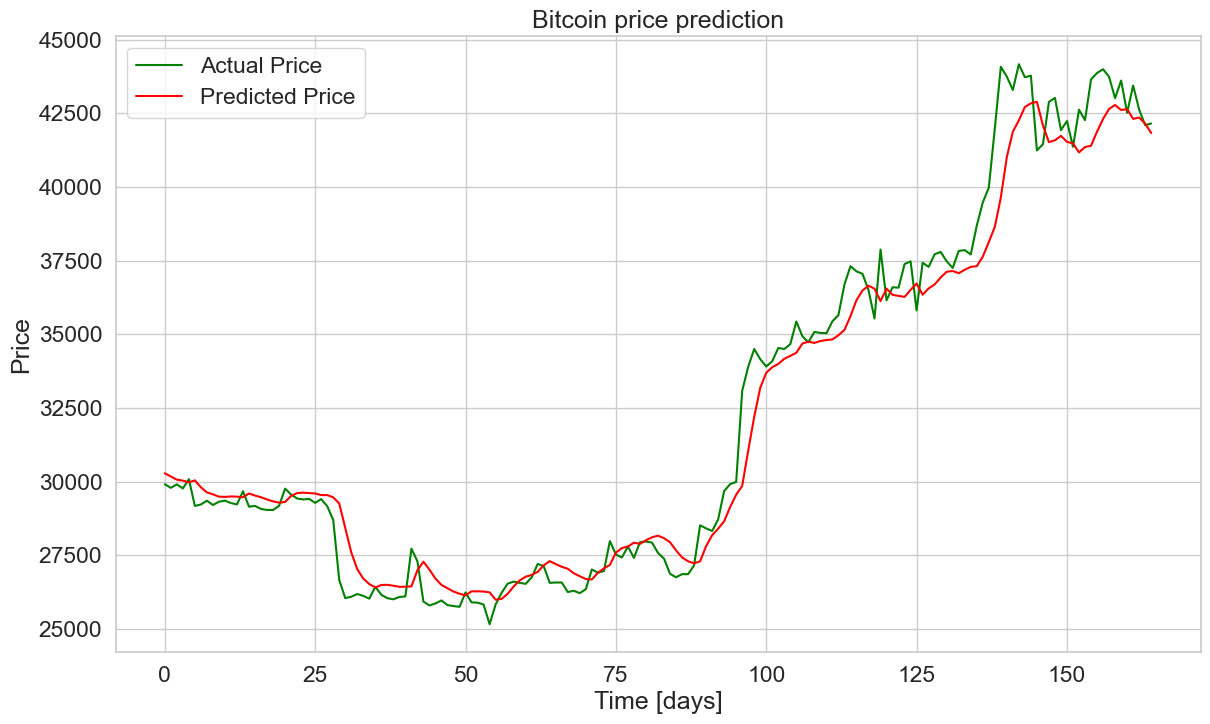

In [24]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
 
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('Bitcoin price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show();

## Conclusion

## References

- 1. https://www.analyticsvidhya.com/blog/2021/03/introduction-to-long-short-term-memory-lstm/


# Multiple Models

In [41]:
def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)


# Function to preprocess data
def preprocess_data(data_raw, seq_len, train_split):
    data = to_sequences(data_raw, seq_len)
    num_train = int(train_split * data.shape[0])
    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]
    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]
    return X_train, y_train, X_test, y_test


In [48]:
SEQ_LEN = 100
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1

# Function to train a model
def train_model(X_train, y_train, X_test, y_test):
    

    input_shape = (WINDOW_SIZE, X_train.shape[-1])
    inputs = Input(shape=input_shape)
    model = keras.Sequential()
    model.add(inputs)
    model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=True)))
    model.add(Dropout(rate=DROPOUT))
    model.add(Bidirectional(LSTM((WINDOW_SIZE * 2), return_sequences=True)))
    model.add(Dropout(rate=DROPOUT))
    model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=False)))
    model.add(Dense(units=1))
    model.add(Activation('linear'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    history = model.fit(X_train, y_train, epochs=50, batch_size=BATCH_SIZE, shuffle=False, validation_split=0.1)
    return model, history


In [49]:
# Function to plot loss history
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


In [50]:
# Function to make predictions and plot results
def predict_and_plot(model, X_test, y_test, scaler, currency):
    y_hat = model.predict(X_test)
    y_test_inverse = scaler.inverse_transform(y_test)
    y_hat_inverse = scaler.inverse_transform(y_hat)
    plt.plot(y_test_inverse, label="Actual Price", color='green')
    plt.plot(y_hat_inverse, label=f"{currency} Price", color='red')
    plt.title(f"{currency} Price")
    plt.xlabel('Time [days]')
    plt.ylabel('Price')
    plt.legend(loc='best')
    plt.show()

Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 23s 392ms/step - loss: 0.0027 - val_loss: 0.0073
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 17s 381ms/step - loss: 0.0086 - val_loss: 0.0041
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 19s 426ms/step - loss: 0.0081 - val_loss: 0.0015
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 19s 442ms/step - loss: 0.0135 - val_loss: 0.0025
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 20s 451ms/step - loss: 0.0107 - val_loss: 0.0279
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 19s 423ms/step - loss: 0.0025 - val_loss: 0.0109
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 18s 419ms/step - loss: 7.7796e-04 - val_loss: 0.0066
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 18s 415ms/step - loss: 9.8521e-04 - val_loss: 0.0012
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 19s 437ms/step - loss: 0.0017 - val_loss: 7.1147e-04
Epoch 10/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 20s 449ms/step - loss: 7.2674e-04 - val_loss: 5.9570e-04
Epoch 11/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 20s 463ms/step - loss: 3.1191e-04 - val_loss: 0.0026
Epoch 12/50
44/44

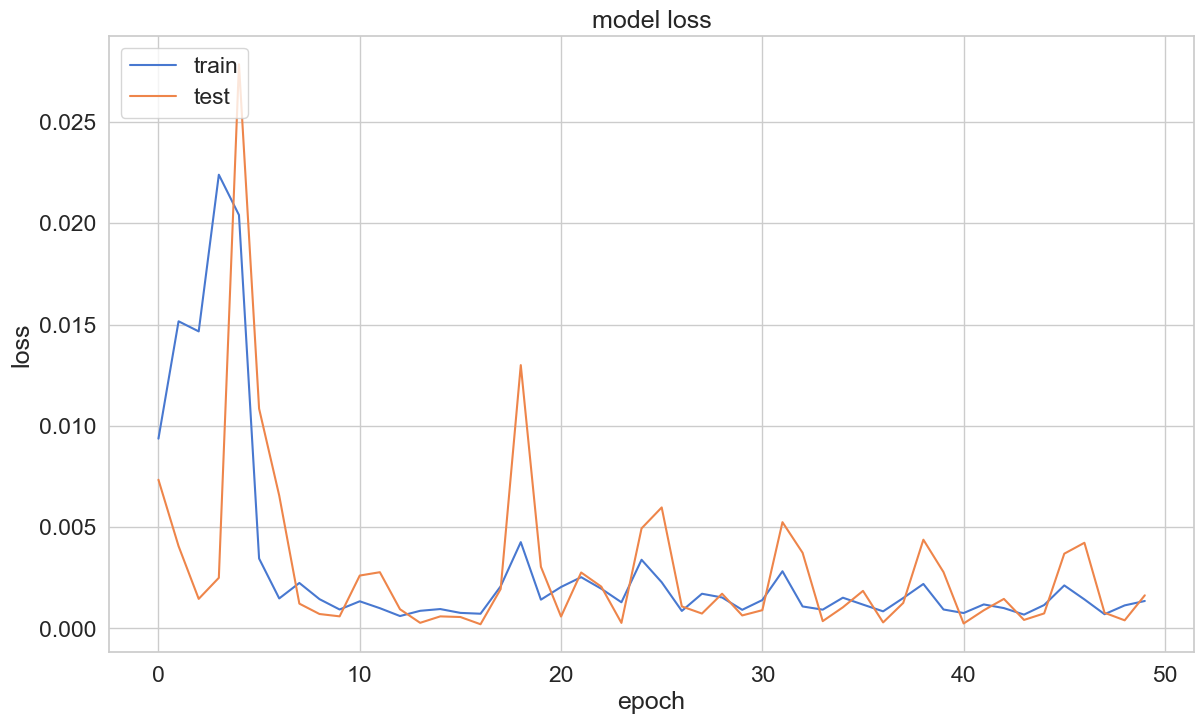

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step


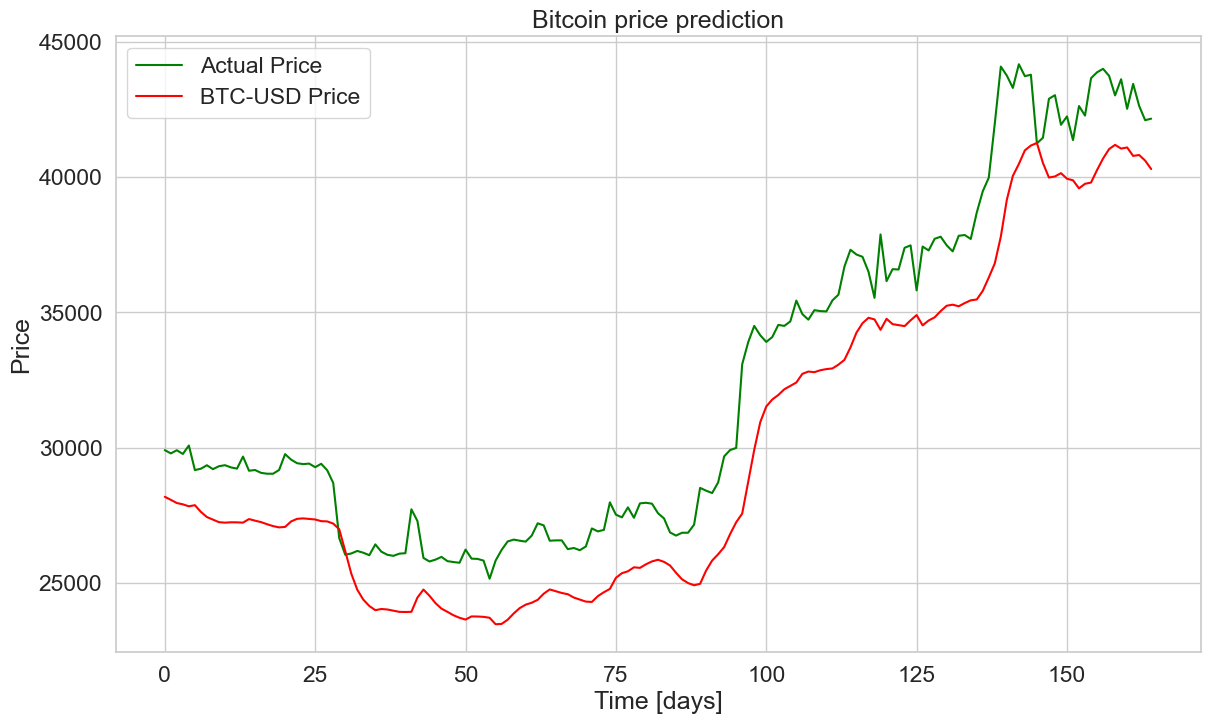

Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 340ms/step - loss: 0.0078 - val_loss: 0.0054
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 317ms/step - loss: 0.0122 - val_loss: 0.0168
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 317ms/step - loss: 0.0169 - val_loss: 0.0145
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 396ms/step - loss: 0.0169 - val_loss: 7.6322e-04
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 437ms/step - loss: 0.0076 - val_loss: 0.0017
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 433ms/step - loss: 0.0043 - val_loss: 0.0180
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 440ms/step - loss: 0.0053 - val_loss: 8.9328e-04
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 443ms/step - loss: 0.0018 - val_loss: 0.0026
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 442ms/step - loss: 0.0010 - val_loss: 0.0032
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 12s 431ms/step - loss: 7.0370e-04 - val_loss: 2.7209e-04
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 439ms/step - loss: 5.2015e-04 - val_loss: 0.0013
Epoch 12/50
29/29 ━━━━━

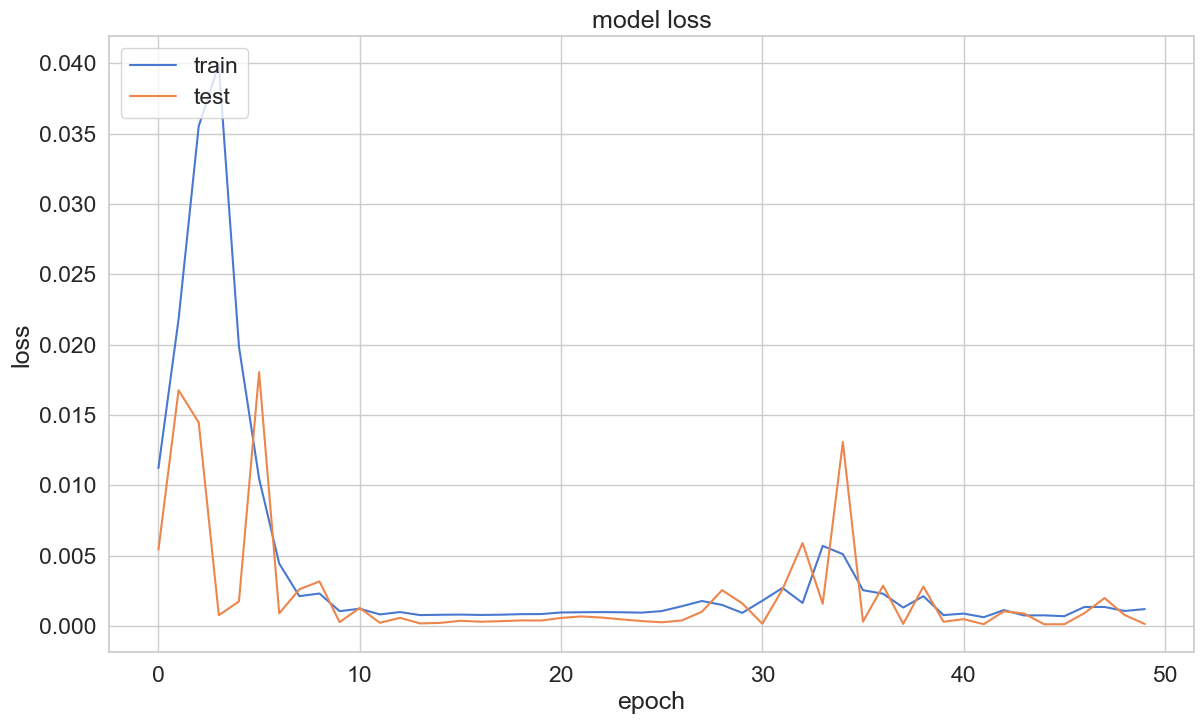

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step


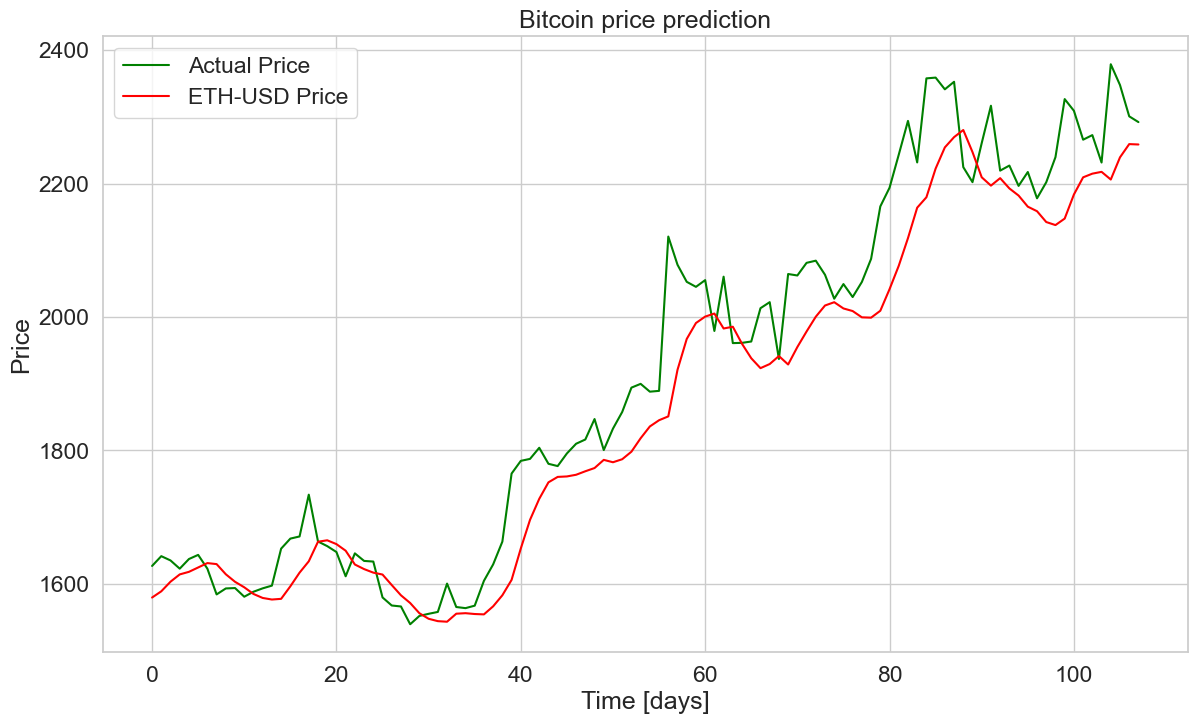

Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 353ms/step - loss: 0.0092 - val_loss: 1.6342e-04
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 331ms/step - loss: 0.0342 - val_loss: 9.7852e-04
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 330ms/step - loss: 0.0115 - val_loss: 3.3495e-04
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 333ms/step - loss: 0.0140 - val_loss: 0.0011
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 328ms/step - loss: 0.0034 - val_loss: 0.0012
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 400ms/step - loss: 0.0254 - val_loss: 8.1082e-04
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 451ms/step - loss: 0.0029 - val_loss: 8.4127e-05
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 469ms/step - loss: 0.0100 - val_loss: 5.7267e-04
Epoch 9/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 665ms/step - loss: 0.0102 - val_loss: 1.0984e-04
Epoch 10/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 455ms/step - loss: 0.0350 - val_loss: 0.0038
Epoch 11/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 480ms/step - loss: 0.0044 - val_loss: 1.7740e-04
Epoch 12/50
17/17 

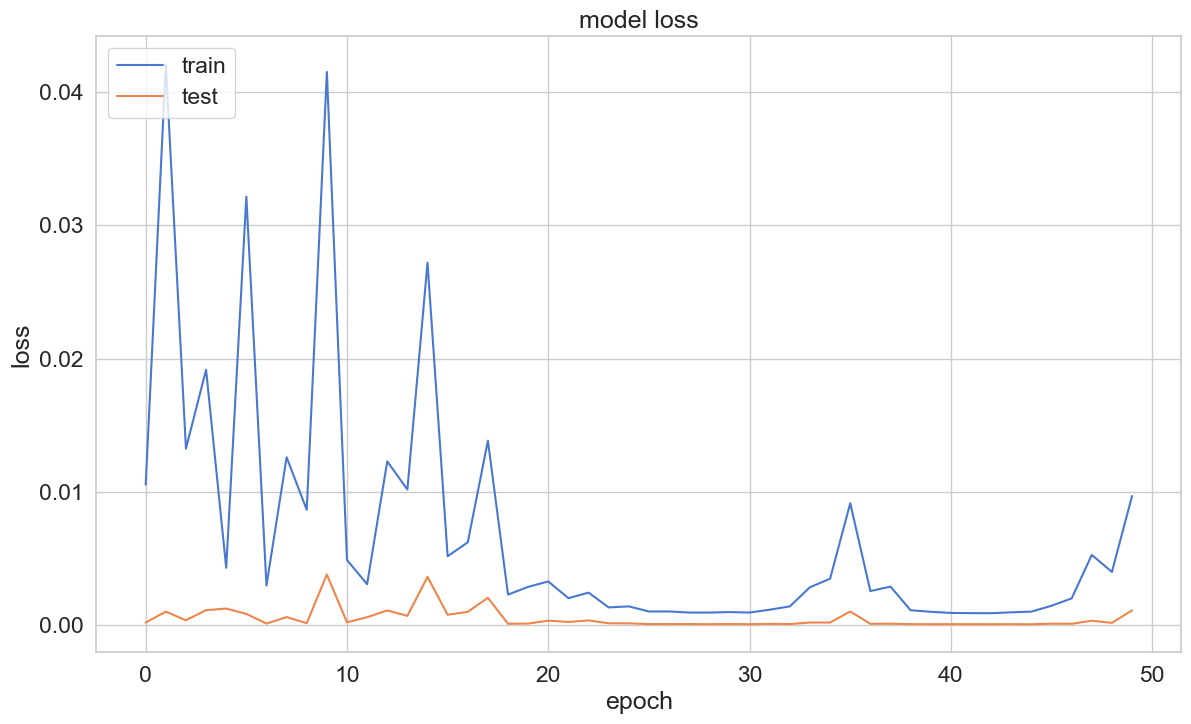

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step


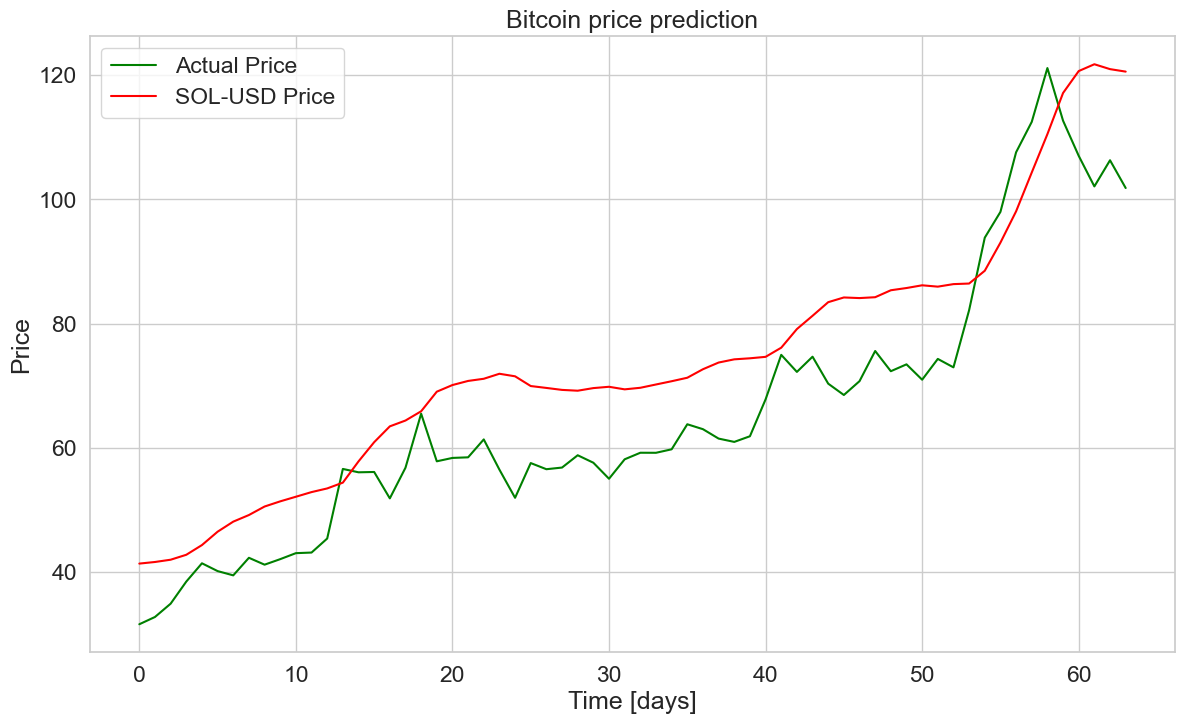

Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 14s 350ms/step - loss: 0.0152 - val_loss: 0.0403
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 331ms/step - loss: 0.0139 - val_loss: 0.0180
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 324ms/step - loss: 0.0128 - val_loss: 0.0139
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 12s 403ms/step - loss: 0.0051 - val_loss: 0.0128
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 451ms/step - loss: 0.0024 - val_loss: 0.0087
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 451ms/step - loss: 0.0014 - val_loss: 0.0040
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 449ms/step - loss: 7.0643e-04 - val_loss: 6.7779e-04
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 451ms/step - loss: 5.2376e-04 - val_loss: 2.8693e-04
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 458ms/step - loss: 5.9846e-04 - val_loss: 3.4969e-04
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 443ms/step - loss: 8.1230e-04 - val_loss: 8.4537e-04
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 453ms/step - loss: 0.0011 - val_loss: 0.0019
Epoch 12/5

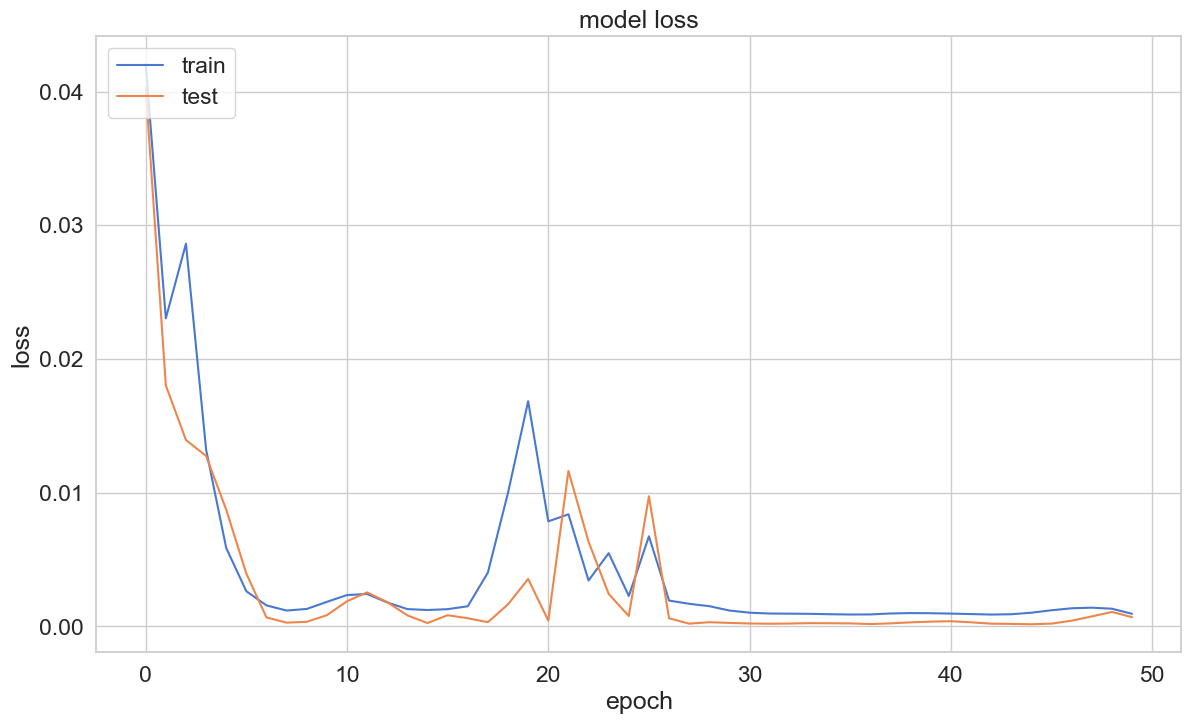

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step


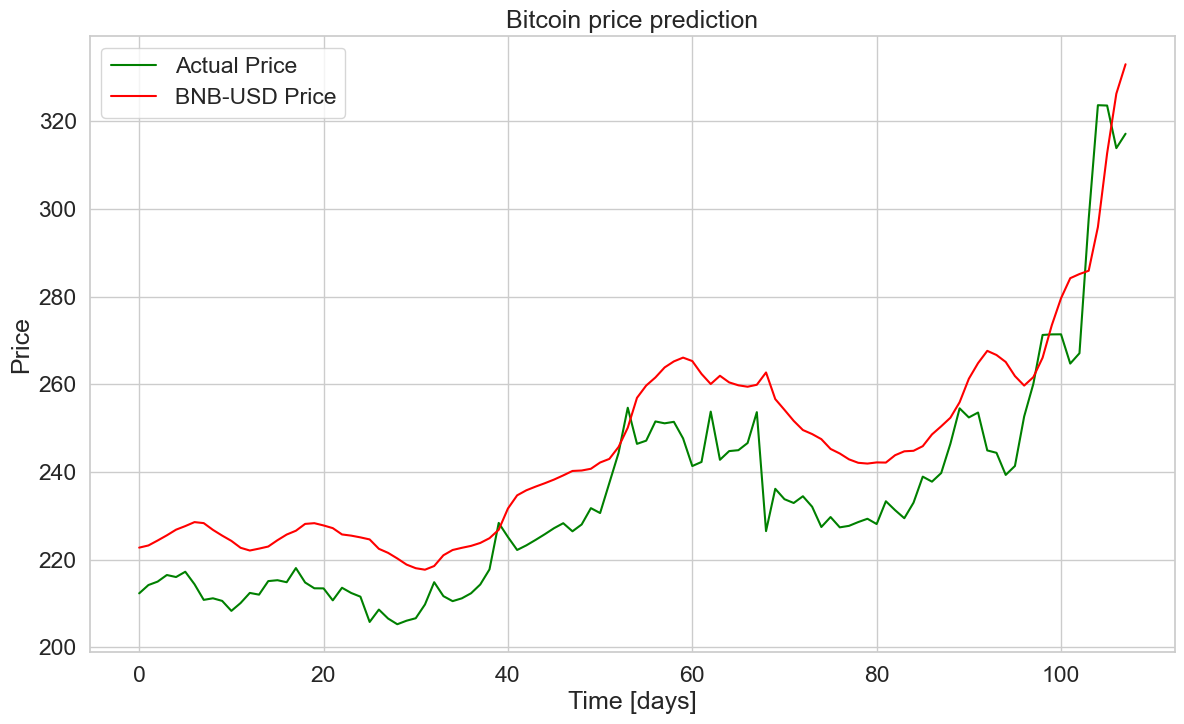

Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 348ms/step - loss: 0.0070 - val_loss: 0.0016
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 336ms/step - loss: 0.0041 - val_loss: 0.0012
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 334ms/step - loss: 0.0038 - val_loss: 3.8500e-04
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 12s 422ms/step - loss: 0.0014 - val_loss: 2.8019e-04
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 444ms/step - loss: 7.6798e-04 - val_loss: 2.2239e-04
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 450ms/step - loss: 4.7190e-04 - val_loss: 2.2906e-04
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 460ms/step - loss: 4.0279e-04 - val_loss: 2.4280e-04
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 449ms/step - loss: 4.5510e-04 - val_loss: 2.4979e-04
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 14s 471ms/step - loss: 4.9370e-04 - val_loss: 2.6608e-04
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 15s 521ms/step - loss: 4.7622e-04 - val_loss: 2.8188e-04
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 456ms/step - loss: 5.0804e-04 

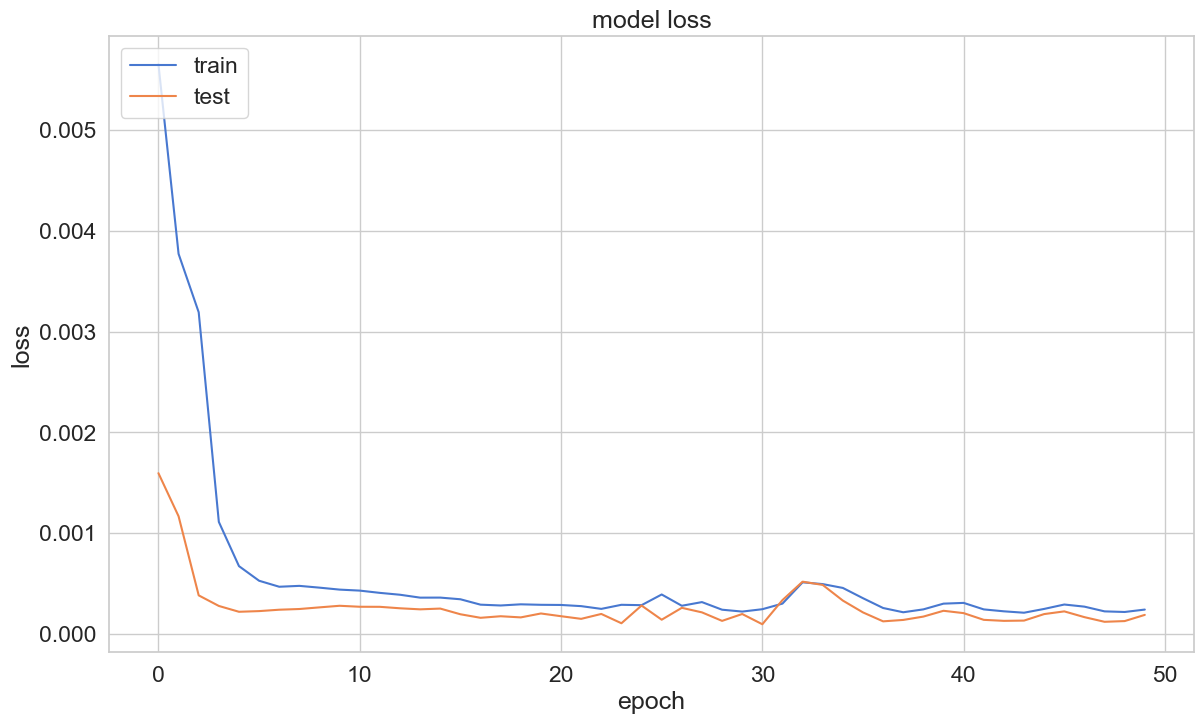

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 214ms/step


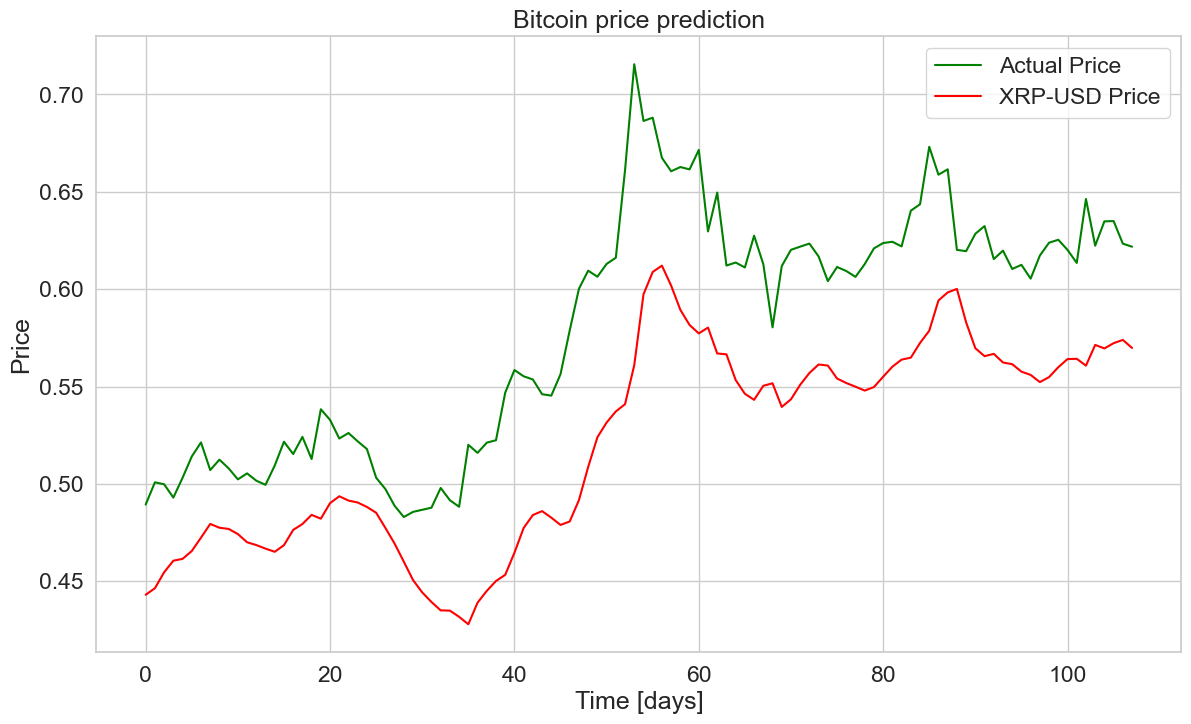

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 18s 654ms/step - loss: 0.0290 - val_loss: 7.3470e-04
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 339ms/step - loss: 0.0252 - val_loss: 2.1557e-04
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 564ms/step - loss: 0.0119 - val_loss: 1.0014e-04
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 328ms/step - loss: 0.0432 - val_loss: 2.9779e-04
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 914s 65s/step - loss: 0.0364 - val_loss: 1.1478e-04
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 661s 47s/step - loss: 0.0218 - val_loss: 1.1594e-04
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 412ms/step - loss: 0.0333 - val_loss: 9.0401e-05
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 449ms/step - loss: 0.0372 - val_loss: 0.0027
Epoch 9/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 546ms/step - loss: 0.0212 - val_loss: 2.5041e-04
Epoch 10/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 505ms/step - loss: 0.0083 - val_loss: 3.3591e-05
Epoch 11/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 533ms/step - loss: 0.0153 - val_loss: 5.4536e-04
Epoch 12/50

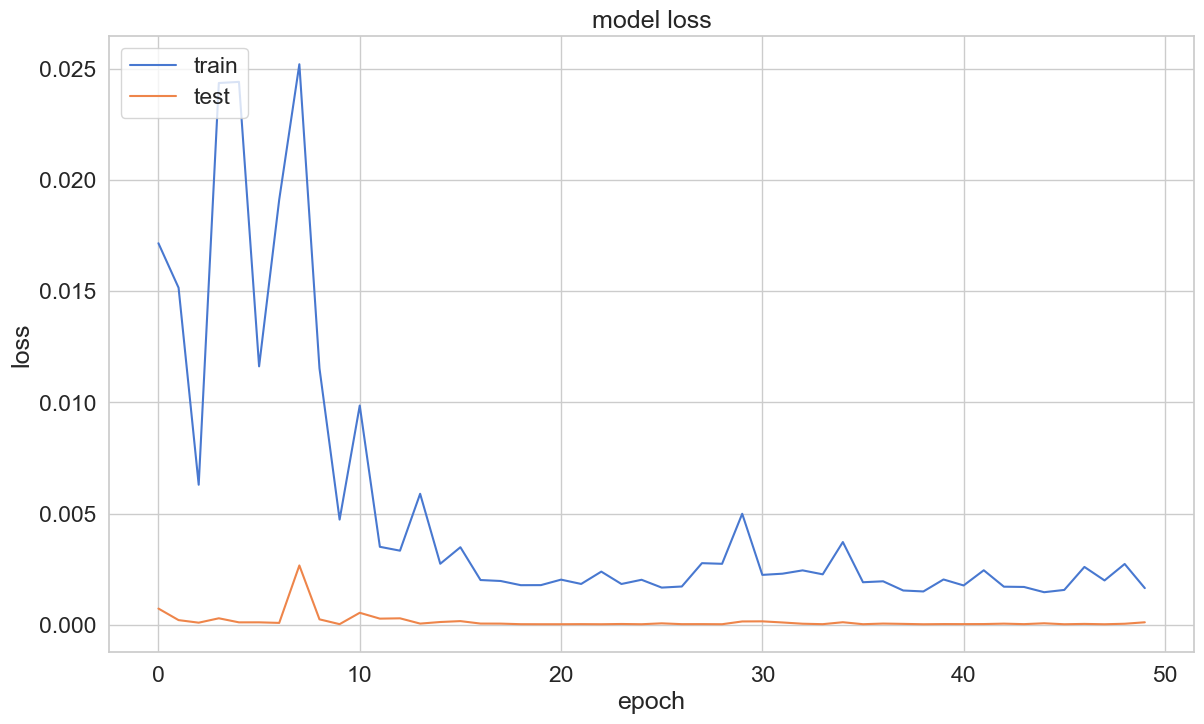

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 461ms/step


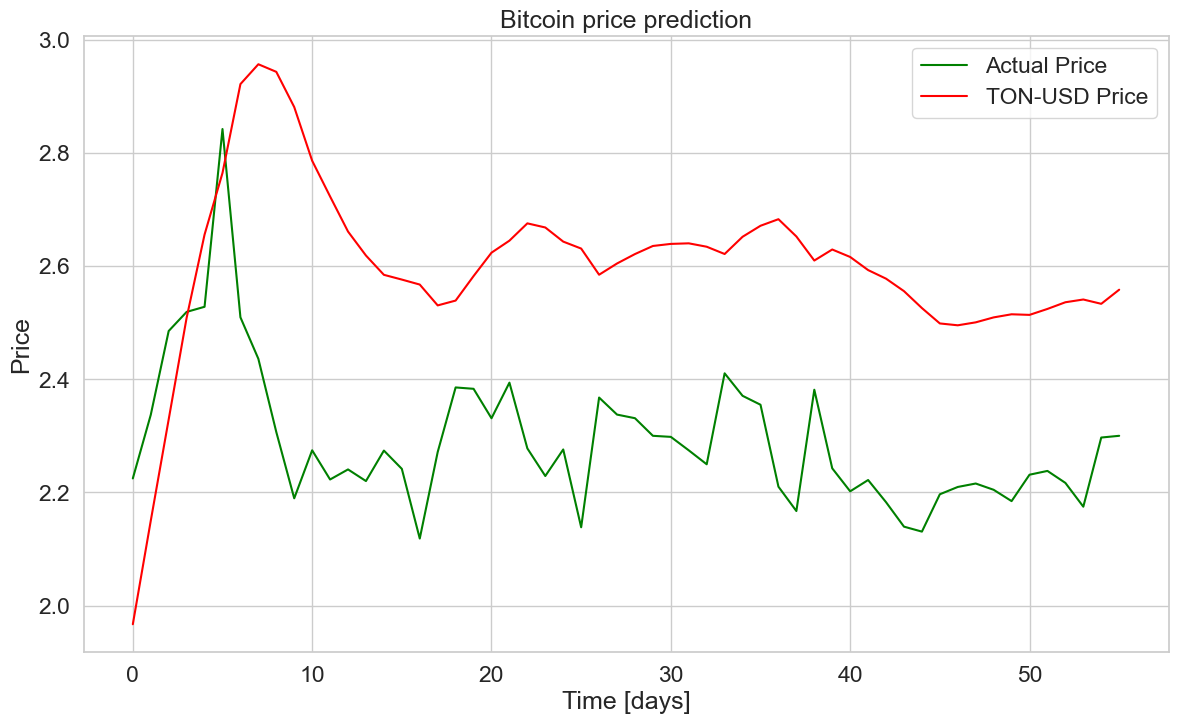

Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 14s 366ms/step - loss: 0.0062 - val_loss: 0.0030
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 323ms/step - loss: 0.0064 - val_loss: 0.0013
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 332ms/step - loss: 0.0040 - val_loss: 0.0040
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 12s 411ms/step - loss: 0.0051 - val_loss: 0.0023
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 446ms/step - loss: 0.0021 - val_loss: 4.1680e-04
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 14s 485ms/step - loss: 7.8262e-04 - val_loss: 9.3379e-04
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 14s 474ms/step - loss: 0.0011 - val_loss: 1.5427e-04
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 452ms/step - loss: 0.0048 - val_loss: 0.0045
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 453ms/step - loss: 0.0011 - val_loss: 2.0951e-04
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 455ms/step - loss: 0.0027 - val_loss: 0.0020
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 452ms/step - loss: 7.3440e-04 - val_loss: 1.0333e-04
Epoch 12/50
29

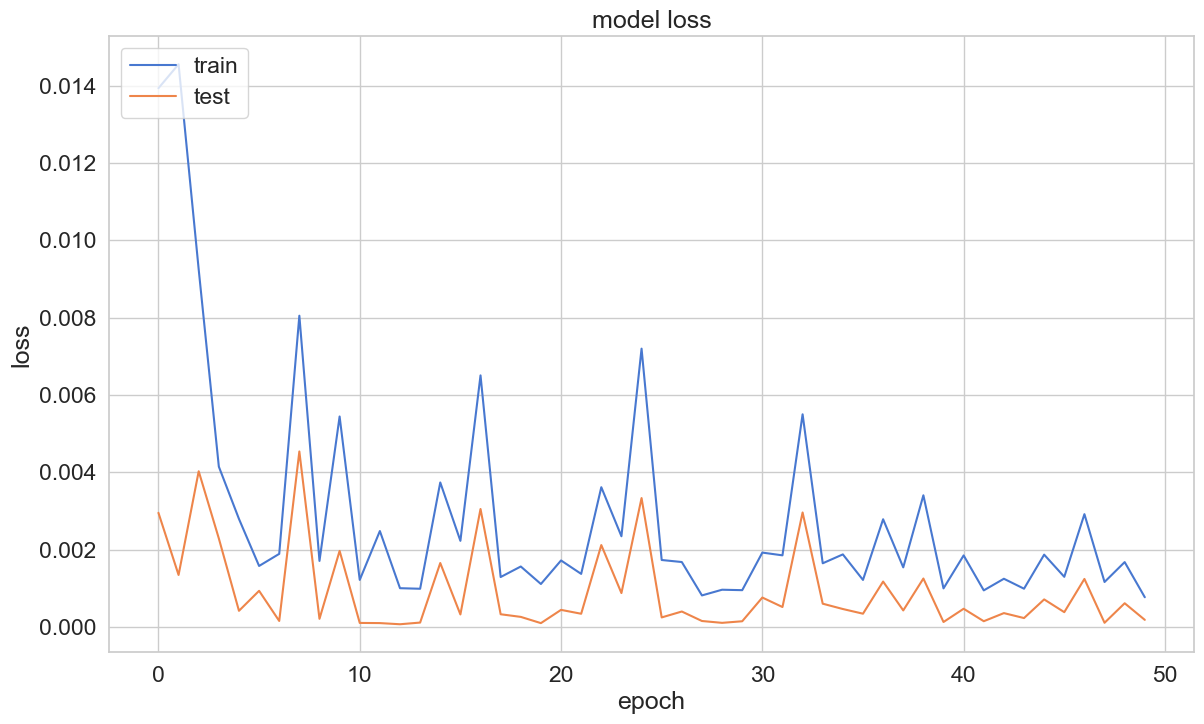

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step


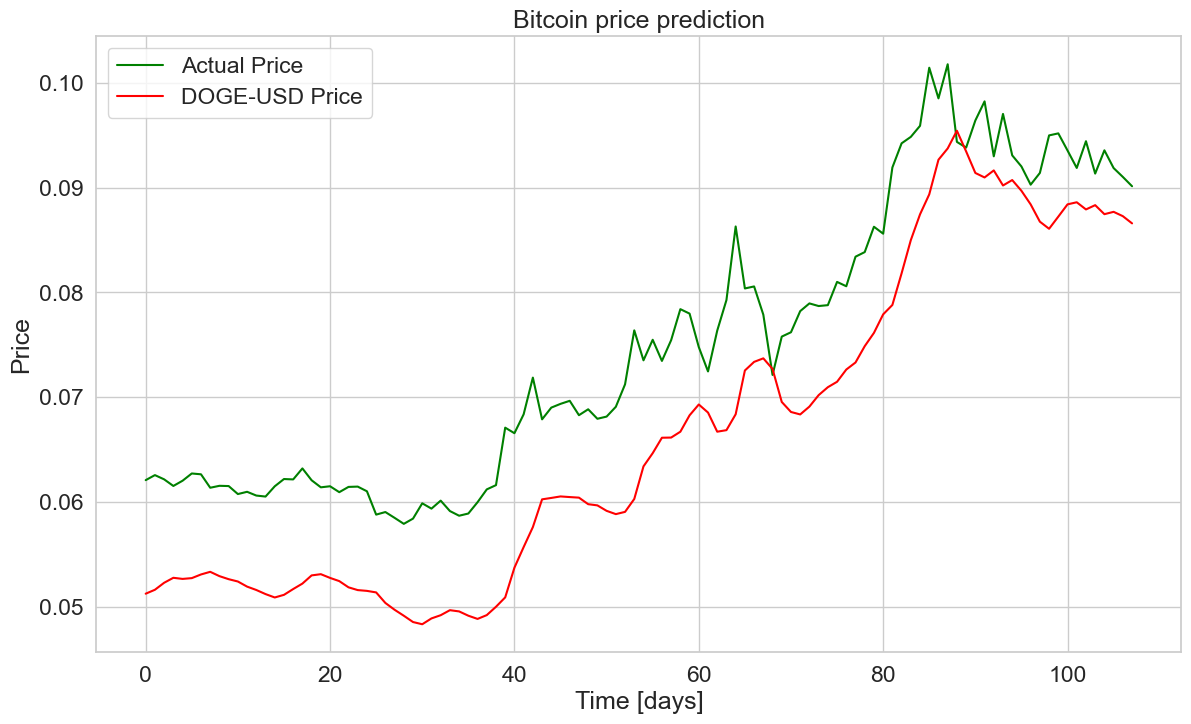

Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 346ms/step - loss: 0.0105 - val_loss: 3.5004e-04
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 346ms/step - loss: 0.0113 - val_loss: 1.9251e-04
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 367ms/step - loss: 0.0066 - val_loss: 0.0049
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 12s 405ms/step - loss: 0.0046 - val_loss: 8.1818e-04
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 462ms/step - loss: 0.0010 - val_loss: 1.5496e-04
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 458ms/step - loss: 0.0085 - val_loss: 0.0123
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 462ms/step - loss: 0.0046 - val_loss: 4.4972e-04
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 461ms/step - loss: 6.4658e-04 - val_loss: 1.6754e-04
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 453ms/step - loss: 0.0020 - val_loss: 8.7346e-04
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 463ms/step - loss: 0.0026 - val_loss: 1.8069e-04
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 456ms/step - loss: 0.0076 - val_loss: 0.0038
Epoch

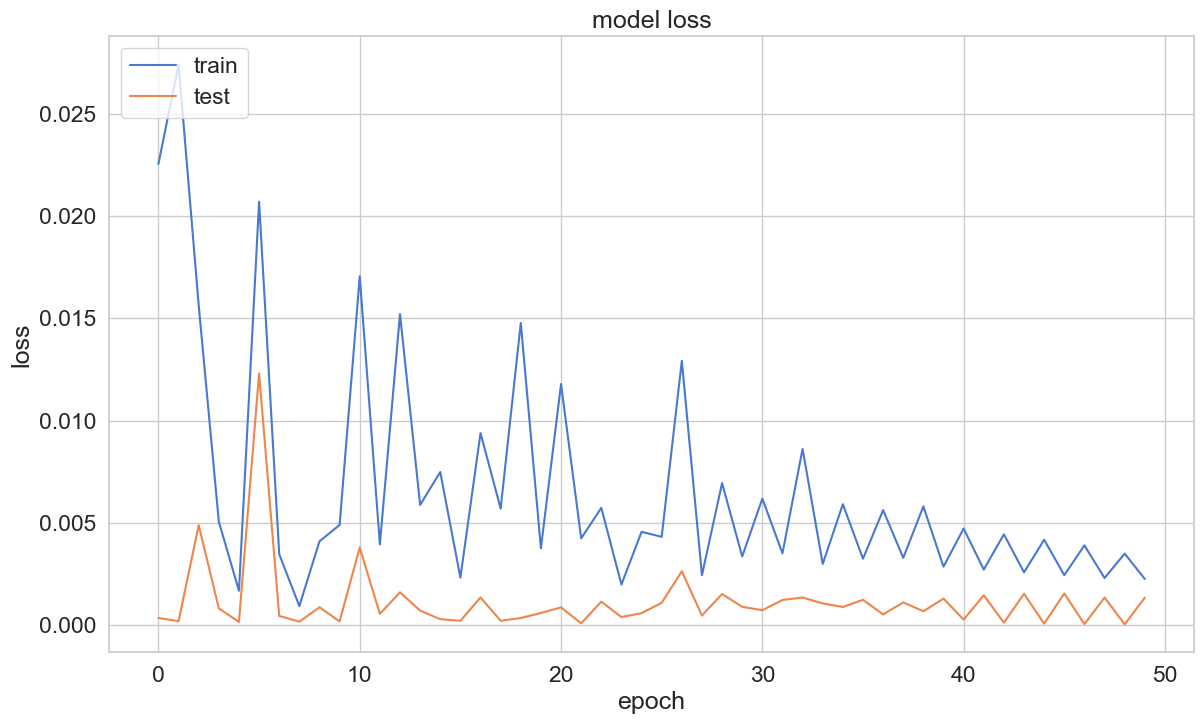

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step


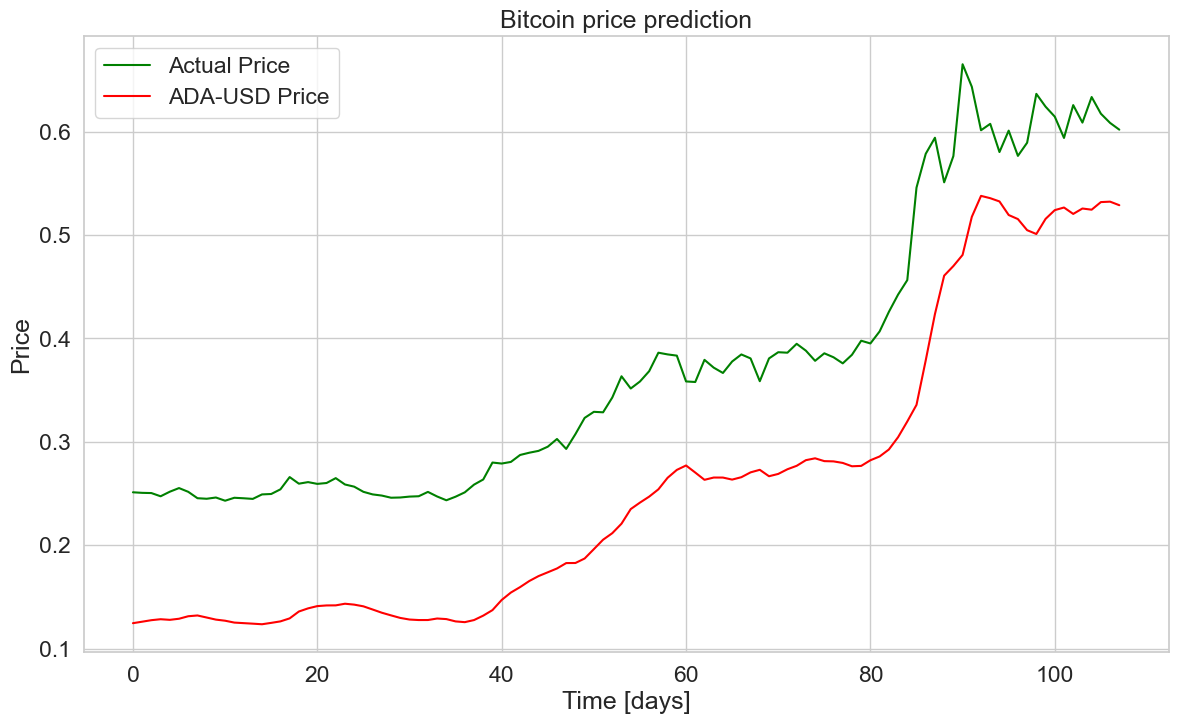

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 380ms/step - loss: 0.0087 - val_loss: 0.0013
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 352ms/step - loss: 0.0235 - val_loss: 0.0035
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step - loss: 0.0100 - val_loss: 4.5206e-04
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 332ms/step - loss: 0.0077 - val_loss: 0.0012
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0101 - val_loss: 1.2821e-04
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 334ms/step - loss: 0.0035 - val_loss: 7.6833e-05
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 442ms/step - loss: 0.0049 - val_loss: 6.4091e-05
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 538ms/step - loss: 0.0107 - val_loss: 0.0014
Epoch 9/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 484ms/step - loss: 0.0044 - val_loss: 1.1341e-04
Epoch 10/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 467ms/step - loss: 0.0069 - val_loss: 2.5392e-04
Epoch 11/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 464ms/step - loss: 0.0159 - val_loss: 0.0043
Epoch 12/50
15/15 ━━━━━━━━━━

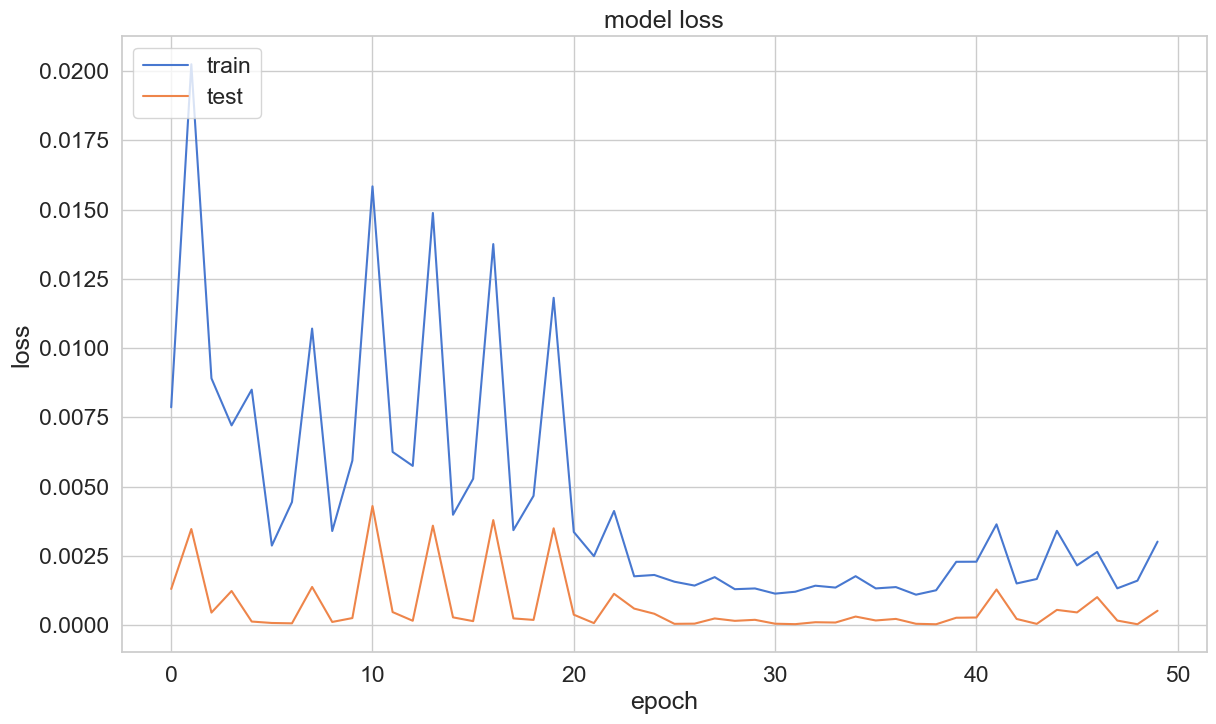

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 456ms/step


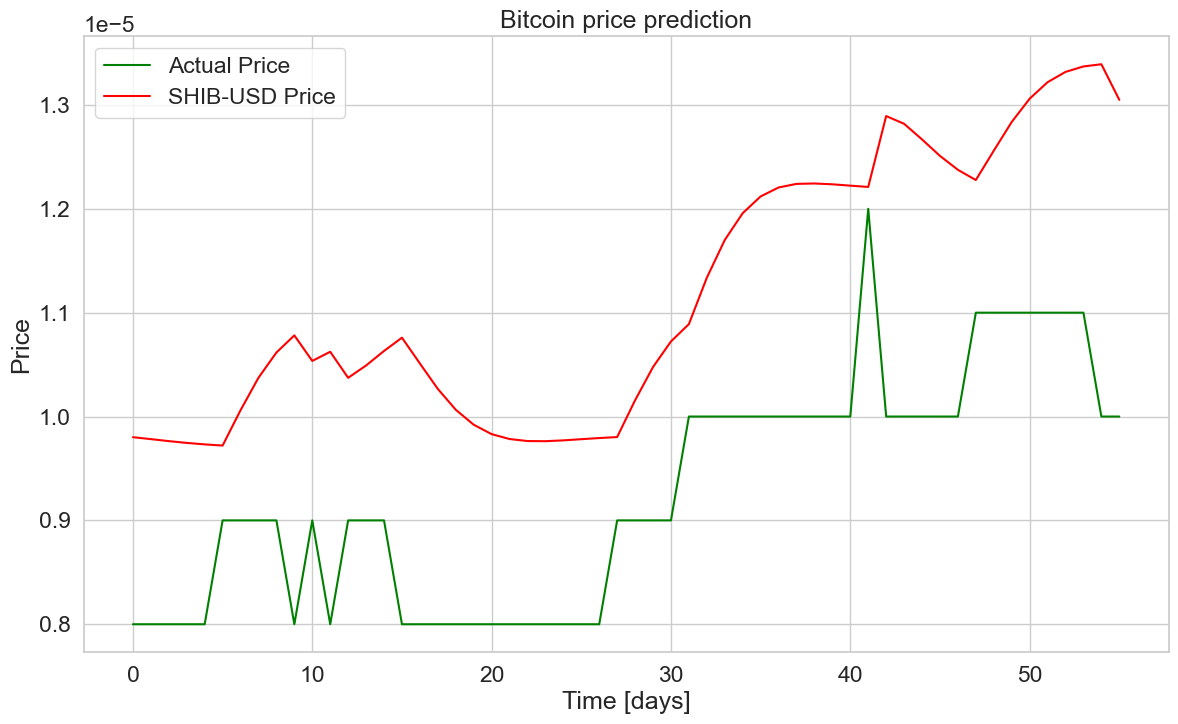

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 336ms/step - loss: 0.0204 - val_loss: 6.6369e-04
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 305ms/step - loss: 0.0260 - val_loss: 0.0194
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 312ms/step - loss: 0.0222 - val_loss: 0.0017
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 310ms/step - loss: 0.0188 - val_loss: 1.1655e-04
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 312ms/step - loss: 0.0262 - val_loss: 2.7308e-04
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - loss: 0.0195 - val_loss: 3.3516e-04
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 382ms/step - loss: 0.0293 - val_loss: 3.7190e-05
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 413ms/step - loss: 0.0187 - val_loss: 2.0793e-04
Epoch 9/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 438ms/step - loss: 0.0179 - val_loss: 1.7047e-04
Epoch 10/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 420ms/step - loss: 0.0415 - val_loss: 0.0052
Epoch 11/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 436ms/step - loss: 0.0105 - val_loss: 0.0013
Epoch 12/50
15/15 ━━━━━━

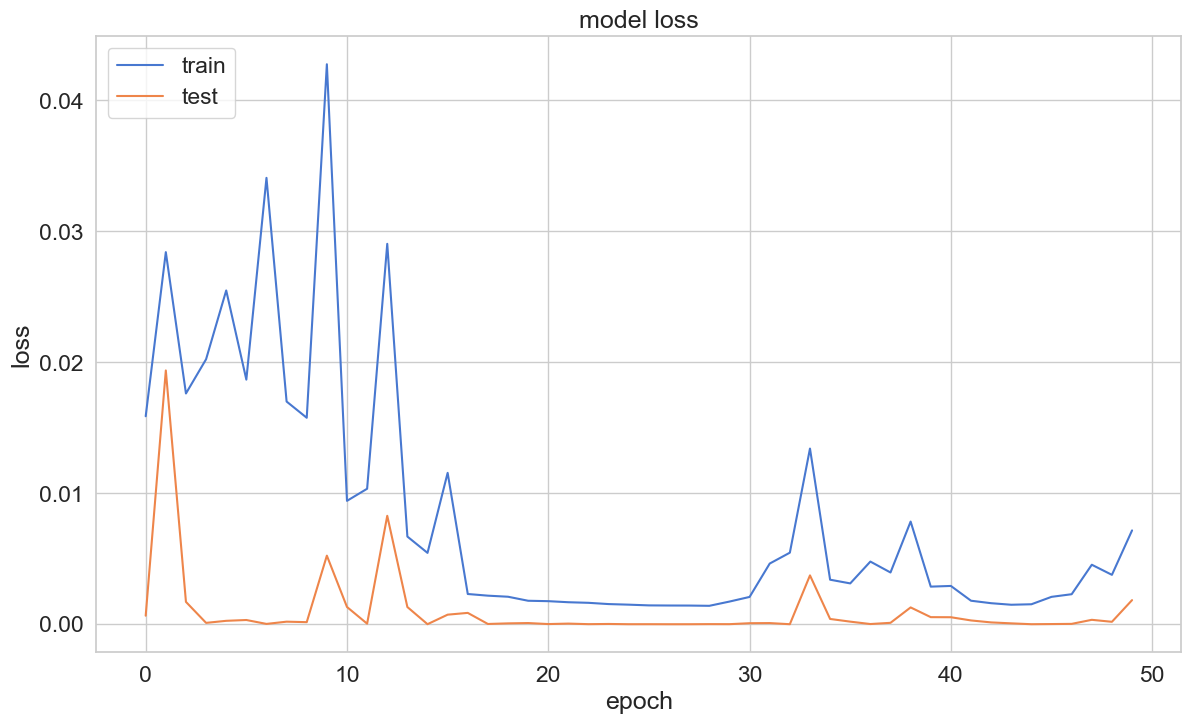

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 391ms/step


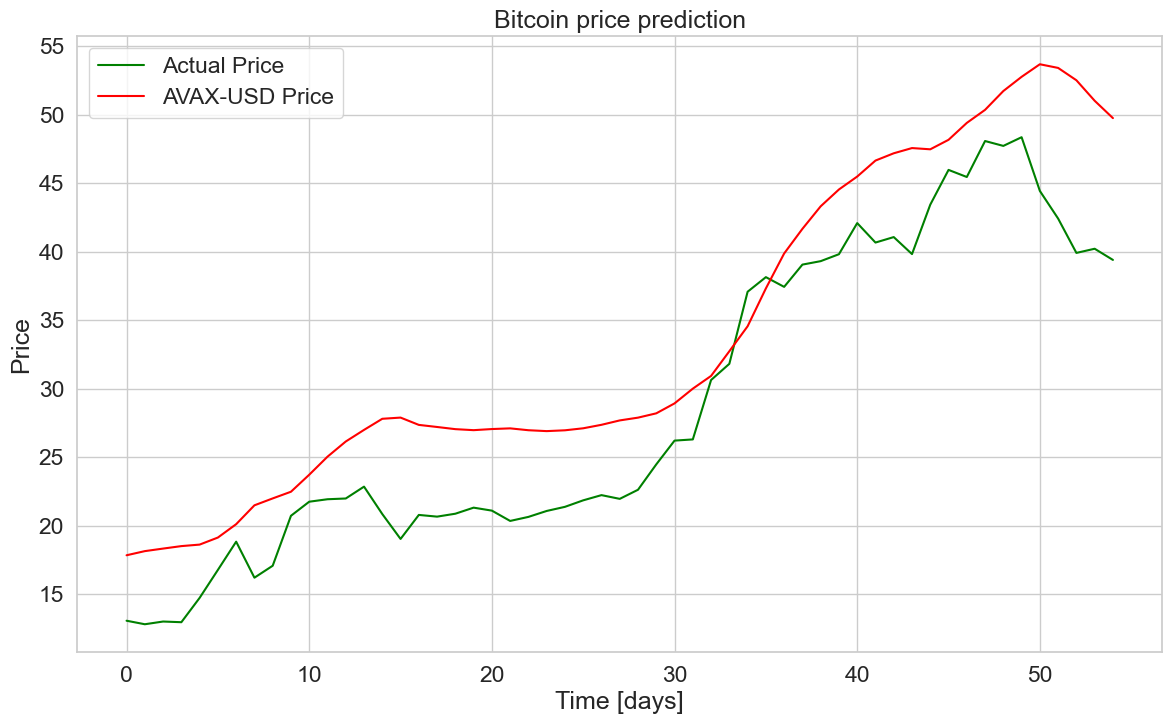

In [51]:
currencies = ['BTC-USD', 'ETH-USD', 'SOL-USD', 'BNB-USD', 'XRP-USD', 'TON-USD', 'DOGE-USD', 'ADA-USD', 'SHIB-USD', 'AVAX-USD']


# Main function to iterate over multiple datasets
def main():

    models = {}
    histories = {}
    X_tests = {}
    y_tests = {}
    scalers = {}

    for currency in currencies:
        csv_path = f'./data/{currency}_data.csv'
        df = pd.read_csv(csv_path, parse_dates=['Date'])
        close_price = df['Close'].values.reshape(-1, 1)
        scaled_close = scaler.fit_transform(close_price)
        X_train, y_train, X_test, y_test = preprocess_data(scaled_close, SEQ_LEN, train_split=0.95)
        model, history = train_model(X_train, y_train, X_test, y_test)
        plot_loss(history)
        predict_and_plot(model, X_test, y_test, scaler, currency)

        models[currency] = model
        histories[currency] = history
        X_tests[currency] = X_test
        y_tests[currency] = y_test
        scalers[currency] = scaler
    return models, histories, X_tests, y_tests, scalers

# Call the main function
models, histories, X_tests, y_tests, scalers = main()

In [52]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Function to calculate evaluation metrics
def calculate_metrics(model, X_test, y_test, scaler):
    y_hat = model.predict(X_test)
    y_test_inverse = scaler.inverse_transform(y_test)
    y_hat_inverse = scaler.inverse_transform(y_hat)
    mse = mean_squared_error(y_test_inverse, y_hat_inverse)
    rmse = mean_squared_error(y_test_inverse, y_hat_inverse, squared=False)
    mae = mean_absolute_error(y_test_inverse, y_hat_inverse)
    return mse, rmse, mae

# Main function to compare models
def compare_models(models, histories, currencies):
    evaluation_results = []
    for currency in currencies:
        model = models[currency]
        history = histories[currency]
        X_test = X_tests[currency]
        y_test = y_tests[currency]
        scaler = scalers[currency]
        mse, rmse, mae = calculate_metrics(model, X_test, y_test, scaler)
        evaluation_results.append({'Currency': currency, 'MSE': mse, 'RMSE': rmse, 'MAE': mae})
    return pd.DataFrame(evaluation_results)

# Call the comparison function
evaluation_table = compare_models(models, histories, currencies)
print(evaluation_table)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step

/Users/ephraim888sun/.pyenv/versions/3.9.6/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


/Users/ephraim888sun/.pyenv/versions/3.9.6/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/ephraim888sun/.pyenv/versions/3.9.6/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step

/Users/ephraim888sun/.pyenv/versions/3.9.6/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


/Users/ephraim888sun/.pyenv/versions/3.9.6/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/ephraim888sun/.pyenv/versions/3.9.6/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
2/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step

/Users/ephraim888sun/.pyenv/versions/3.9.6/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


/Users/ephraim888sun/.pyenv/versions/3.9.6/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/ephraim888sun/.pyenv/versions/3.9.6/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
   Currency        MSE      RMSE       MAE
0   BTC-USD  23.839591  4.882580  4.570306
1   ETH-USD   4.780069  2.186337  1.663612
2   SOL-USD  30.071347  5.483735  5.048847
3   BNB-USD   7.306728  2.703096  2.473624
4   XRP-USD   6.675313  2.583663  2.410919
5   TON-USD   3.920722  1.980081  1.854713
6  DOGE-USD   3.112001  1.764087  1.654612
7   ADA-USD  28.030675  5.294400  5.189077
8  SHIB-USD  10.845562  3.293260  3.141078
9  AVAX-USD  31.310610  5.595588  4.960198


/Users/ephraim888sun/.pyenv/versions/3.9.6/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
